In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
# For wide monitor
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
mnist_csv = pd.read_csv("./mnist_train.csv", header=None, skiprows=1).values
print(mnist_csv.shape)

(59999, 785)


In [4]:
train, test = train_test_split(mnist_csv, test_size=0.3, random_state=1)
print(train.shape)
print(test.shape)

(41999, 785)
(18000, 785)


In [5]:
Y_train, X_train = np_utils.to_categorical(train[:, 0]), train[:, 1:]
Y_test, X_test = np_utils.to_categorical(test[:, 0]), test[:, 1:]
print(Y_train.shape, X_train.shape)
print(Y_test.shape, X_test.shape)

(41999, 10) (41999, 784)
(18000, 10) (18000, 784)


In [6]:
X_train = (X_train)/255.
X_test = (X_test)/255.

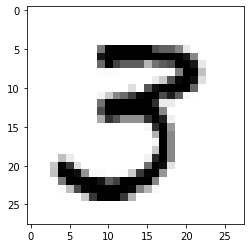

In [7]:
plt.imshow(np.reshape(X_train[0], (28, 28)), cmap=plt.cm.gray_r)

In [8]:
X = tf.placeholder(tf.float32, [None, 784]) # Input, 784개의 값을 가지며 n개의 이미지이다.
X_img = tf.reshape(X, [-1, 28, 28, 1]) # input을 이미지로 인식하기 위해 reshape을 해준다. 28*28의 이미지이며 단일색상, 개수는 n개이므로 -1
Y = tf.placeholder(tf.float32, [None, 10]) # output

In [9]:
# (28, 28, 1)
# Layer1
# 3*3 크기의 필터, 색상은 단일, 총 16개의 필터
W1 = tf.Variable(tf.random_normal([3,3,1,16], stddev=0.01))
# conv2d를 통과해도 28*28 크기를 가짐, 대신 16개의 필터이므로 총 16개의 결과가 생김
L1 = tf.nn.conv2d(X_img, W1, strides=[1,1,1,1], padding='SAME')
# (28, 28, 16)
L1 = tf.nn.relu(L1)
# max pooling을 하고 나면 스트라이드 및 패딩 설정에 의해 14*14 크기의 결과가 나옴
L1 = tf.nn.max_pool(L1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')


# -> 들어오는 input 데이터를 처리하고, 이를 이미지로 인식시킵니다.
# 그리고 첫번째 레이어를 확인해보면, stride는 1, padding은 SAME으로 설정하여 convolution layer를 통과시키고, 이후
# relu를 통과시킨 후에 max pooling을 합니다. 이렇게 첫번째 리에어를 통과하면 그 결과는 14*14의 형태를 가지게 된다.



# (14, 14, 16)
# Layer2
# 이번에는 32개의 필터
W2 = tf.Variable(tf.random_normal([3,3,16,32], stddev=0.01))
# con2d layer를 통과시키면, [?, 14, 14, 64] 형태를 가짐
L2 = tf.nn.conv2d(L1, W2, strides=[1, 1, 1, 1], padding='SAME')
L2 = tf.nn.relu(L2)
# max pooling에서 stride가 2 이므로 결과는 7*7의 형태를 가짐
L2 = tf.nn.max_pool(L2, ksize=[1, 2, 2, 1], strides=[1,2,2,1], padding='SAME')

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
# 이후 쭉 펼친다.
L2_flat = tf.reshape(L2, [-1, 7*7*32])

# fully_connected layer
# 두번째 레이어를 통과한 결과 값을 fully-connected layer에 통과시킵니다.
W3 = tf.Variable(tf.random_normal([7*7*32,10], stddev=0.01))
b = tf.Variable(tf.random_normal([10]))
logits = tf.matmul(L2_flat, W3)+b

In [11]:
learning_rate = 0.001
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [12]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [13]:
training_epochs = 10
batch_size = 100

In [14]:
# train & test 

for epoch in range(training_epochs):
    avg_loss = 0
    total_batch = int(X_train.shape[0]/batch_size)
    for idx in range(total_batch):
        num = (idx*batch_size)%(X_train.shape[0])
        batch_xs = X_train[num:(num+batch_size)]
        batch_ys = Y_train[num:(num+batch_size)]
        feed_dict = {X: batch_xs, Y: batch_ys}
        c, _ = sess.run([loss, optimizer], feed_dict=feed_dict)
        avg_loss += c/total_batch
    print("Epoch:", "%04d"%(epoch+1), "loss=", "{:.9f}".format(avg_loss))

Epoch: 0001 loss= 0.657471460
Epoch: 0002 loss= 0.231011783
Epoch: 0003 loss= 0.139835918
Epoch: 0004 loss= 0.105685470
Epoch: 0005 loss= 0.087308100
Epoch: 0006 loss= 0.075299464
Epoch: 0007 loss= 0.066444935
Epoch: 0008 loss= 0.059609668
Epoch: 0009 loss= 0.053971065
Epoch: 0010 loss= 0.049248373


In [15]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y_test, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print("Accuracy:", sess.run(accuracy, feed_dict={X: X_test, Y: Y_test}))

Accuracy: 0.97794443


In [16]:
from sklearn.metrics import confusion_matrix
prediction = tf.argmax(logits, 1)
pred = sess.run(prediction, feed_dict={X: X_test})

In [17]:
label = np.argmax(Y_test, axis=1)

In [18]:
print(confusion_matrix(label, pred))

[[1720    0   11    1    0    1    3    0    2    1]
 [   0 1976    6    5    2    0    4    3    4    0]
 [   2    5 1798   14    0    1    0    4    4    1]
 [   1    0    8 1832    0    4    0    2    1    2]
 [   0    5    7    1 1693    0    5    2    6   22]
 [   5    0    0   21    1 1588    6    0   10   11]
 [   5    2    2    1    1    3 1707    0    3    0]
 [   2    5   17   28    4    3    0 1819    2   29]
 [   9    4    5   15    5   10    4    1 1733   18]
 [   1    3    2    4    7    1    1    3    3 1737]]
